I compared the ICRF3 K catalog with the Gaia DR2 catalog (iers_auxilary).

In [1]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = "svg"
# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting, residual_calc02
from my_progs.catalog.pos_diff import nor_sep_calc, pos_diff_calc
from my_progs.catalog.pos_err import pos_err_calc
from my_progs.catalog.write_output import print_vsh1_corr, print_vsh2_corr
from my_progs.stat_func.rms_calc import rms_calc

Load the positional information from these two catalogs.

In [2]:
# Read ICRF3 K catalog
from my_progs.catalog.read_icrf import read_icrf3
icrf3 = read_icrf3(wv="k")

# Read Gaia DR2 IERS quasar data
from my_progs.catalog.read_gaia import read_dr2_iers

gaiadr2 = read_dr2_iers()

# A selection on the G magnitude
bgt_mask = (gaiadr2["phot_g_mean_mag"] >= 18.7)
gaiadr2 = gaiadr2[bgt_mask]
gaiadr2.filled()

iers_name,source_id,ra,ra_err,dec,dec_err,pos_err,parallax,parallax_err,pmra,pmra_err,pmdec,pmdec_err,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,mag,mag,mag
bytes8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2359-221,2340552087337605248,0.5499220984388309,0.4830680409810676,-21.8860734515098,0.3214542550971185,0.4831047772372843,-1.2254791228136077,0.5329940012064253,-0.034637706078405564,0.8855496468586489,-0.05961199228747711,0.7657056040084157,-0.013836138,0.39026165,0.44715494,-0.10128507,-0.081793234,0.007855844,0.5445474,-0.060944,-0.17351532,0.21098249,19.258053,19.407907,17.85715
0000-199,2365814049884978048,0.8164555380378795,0.31214484752059934,-19.697333393384483,0.20132065134575663,0.31218319151974,-0.24976210176238237,0.36241695927078477,0.6167410883691041,0.5467370543754372,-0.20622857222487195,0.4638258235243829,0.01857697,0.46789265,0.3675997,-0.17307134,-0.20771366,0.066310346,0.5528602,-0.10075016,-0.40074503,0.2787808,19.058247,19.314455,18.64363
0000-197,2365855384650325376,0.8278123681512258,0.2387757610163772,-19.456209949035525,0.1922200644996743,0.24241216451703895,-0.45544305828221626,0.3185109654739551,0.6116734571782345,0.5735415853774198,0.37085954108422414,0.39878223344506625,0.13461179,0.052950118,0.35212186,-0.022328816,-0.097155325,-0.019389542,0.2804625,-0.1926077,-0.35069835,0.24758662,19.193932,19.635006,18.525171
0001-120,2421598528234887680,1.0204794846922574,0.3102386470908995,-11.816218379326092,0.29214212886423696,0.33998919727933147,0.06584825341243254,0.3640494710474267,0.049237658462576495,0.7606129274645607,0.44519648557145636,0.7265389349874076,0.26688337,0.16208343,0.33467895,0.089694664,-0.13309994,0.2532729,0.7076963,-0.11914465,-0.22260411,0.5138607,19.32226,19.66084,18.616665
0001+459,387054966590038656,1.0671982239853723,0.7718284266351787,46.25499167308568,0.6969576827283192,0.777985787941841,-0.029368229696100832,1.0984495193905532,0.9944652987116404,1.2381622163997819,0.4579145221304079,0.9951609005577559,-0.06277916,0.42371804,-0.60506684,0.19084497,0.07386451,0.025139727,-0.6068582,-0.4637956,0.30770168,-0.2570573,20.491125,20.788141,19.799097
0002-478,4978016560925910400,1.1485644787260738,0.32535001967377664,-47.60544549244506,0.38175267275937685,0.4046925099699907,-0.394507921304075,0.5551341682993441,0.10766725569112054,0.5623357858130931,-0.2990603581366252,0.6935629455335646,-0.2602696,0.38209838,-0.3261622,-0.043664124,-0.36382514,0.12289763,-0.07530141,-0.16826801,-0.2654429,-0.06584475,19.847563,19.998808,19.225542
0003-302,2320714900411790720,1.5046805288463183,0.2799168454773056,-29.93058270163919,0.21409983945960212,0.28000657108952953,0.2340647194528872,0.3302528989410066,0.5987007515976515,0.502646727753959,1.198192896049945,0.5233580814317487,0.021342844,0.36650148,0.4671736,0.0780514,-0.22621238,0.13263978,0.49671954,0.015372729,-0.13746421,0.25507668,18.959866,19.044294,18.57586
0003+340,2876677015058834560,1.5307607108816783,0.16438269784399384,34.37233491119163,0.12449342167433461,0.16447708600588248,-0.03426897698288619,0.21299076903826333,-0.4712401093114721,0.33839752540234186,0.6055773439731382,0.20418964209520618,-0.029263731,0.22979577,-0.26855275,0.109804586,-0.07513521,0.12132462,-0.049948186,-0.11239023,0.01076358,-0.10875353,18.713823,18.847193,18.22368


A crossmatch is performed to obtain a sample of common sources.

In [3]:
com_sou = join(icrf3, gaiadr2, keys="iers_name", table_names=["icrf3k", "gaiadr2"])
com_sou

icrf_name,iers_name,type,ra_icrf3k,dec_icrf3k,ra_err_icrf3k,dec_err_icrf3k,ra_dec_corr_icrf3k,mean_obs,pos_err_icrf3k,beg_obs,end_obs,nb_sess,nb_del,source_id,ra_gaiadr2,ra_err_gaiadr2,dec_gaiadr2,dec_err_gaiadr2,pos_err_gaiadr2,parallax,parallax_err,pmra,pmra_err,pmdec,pmdec_err,ra_dec_corr_gaiadr2,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
,,,deg,deg,mas,mas,,,,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,mag,mag,mag
str16,str8,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J000435.6-473619,0002-478,D,1.1485647359583333,-47.60544541102778,0.4516681517736428,1.0827,0.6589,57961.2,1.1267942729306641,57599.3,58067.8,7,13,4978016560925910400,1.1485644787260738,0.32535001967377664,-47.60544549244506,0.38175267275937685,0.4046925099699907,-0.394507921304075,0.5551341682993441,0.10766725569112054,0.5623357858130931,-0.2990603581366252,0.6935629455335646,-0.2602696,0.38209838,-0.3261622,-0.043664124,-0.36382514,0.12289763,-0.07530141,-0.16826801,-0.2654429,-0.06584475,19.847563,19.998808,19.225542
J001101.2-261233,0008-264,--,2.7551947386666664,-26.209271354527775,0.07845899574871043,0.2045,-0.3768,57655.1,0.2069232370376186,57416.9,58070.2,9,298,2335249516418438272,2.7551948192602023,0.26474200864756736,-26.209271412091674,0.19152239774407323,0.2648242736959451,0.48838471517326665,0.33995235834184195,-0.3814735727827663,0.4874481854801042,-0.7575069949813538,0.39611172288816077,0.02380841,0.26370704,0.4832799,-0.14790614,-0.008249272,-0.09487959,0.23874593,-0.05463864,-0.37078896,0.17084321,18.927097,18.99775,18.506237
J001135.2+082355,0009+081,--,2.8969566952083325,8.398773987166667,0.0753827899464934,0.1347,-0.2236,54738.5,0.13617954520385336,52782.5,58082.4,10,579,2751934122352429952,2.8969567637520233,0.4088648539544437,8.398773893073095,0.28601859582721384,0.4824287694436389,0.3793203923570984,0.44324961783411376,-0.9694567981506215,0.7507657608811915,-0.6316320129952357,0.5780635059809789,0.85066354,0.39875883,-0.100092374,-0.59007925,0.41691783,-0.2537835,-0.645995,-0.38118324,-0.51257807,0.44670206,19.144806,19.328686,18.558659
J001259.9-395426,0010-401,--,3.2496242605416663,-39.90723799836111,0.14923621425203867,0.43029999999999996,-0.2606,58090.7,0.43227263006527267,57599.3,58195.8,13,279,4996449220530794624,3.249624229527692,0.23648674084073684,-39.90723759871797,0.16020543208446678,0.23708715979568837,-0.2340148313645632,0.3221290554909662,0.10915603760871935,0.3296586921295444,0.006559704766290048,0.2697861893604811,-0.07778643,0.65060365,-0.74688506,-0.12754063,-0.07361973,-0.029939497,-0.67033136,-0.47706968,-0.097884096,0.029152136,18.870478,19.272543,18.163582
J001611.0-001512,0013-005,D,4.046202320708333,-0.2534569823055556,0.05564945550020629,0.11349999999999998,-0.1558,57881.3,0.11393081828166532,57372.1,58195.8,9,836,2545226894107313280,4.04620223886711,0.5199497615091785,-0.2534567177719667,0.40458852429884573,0.5693752180307423,-0.2668020919110768,0.5850124781518719,0.7958618246788018,1.2942813415451033,0.4021532440687492,0.9046718137399743,0.44188738,0.2626055,0.031097455,-0.2671943,0.13440219,-0.21924527,-0.4057419,0.058564566,-0.038882617,0.3014373,19.783754,20.087801,19.018677
J001937.8+202145,0017+200,D,4.907727053541666,20.362679057500003,0.05160986170648978,0.0867,-0.3386,55236.9,0.0891685546852544,52782.5,58181.5,13,978,2799276958444229632,4.907727043203895,0.3382014645458327,20.36267923318075,0.37192643969619527,0.4376915010924498,-0.21406475053770568,0.4046384018494863,-0.3422472339577014,0.6749746721893458,-0.8732598758881963,0.598024118628734,0.50967795,0.05710892,-0.47218552,-0

There are 2818 common sources: 250 so-called ICRF3 defining sources and 2568 other sources.

Next step is to calculate the positional offset (ICRF3SX - GaiaDR2).

In [4]:
[dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d,
 X] = pos_diff_calc(com_sou["ra_icrf3k"], com_sou["ra_err_icrf3k"],
                    com_sou["dec_icrf3k"], com_sou["dec_err_icrf3k"],
                    com_sou["ra_dec_corr_icrf3k"], com_sou["ra_gaiadr2"],
                    com_sou["ra_err_gaiadr2"], com_sou["dec_gaiadr2"],
                    com_sou["dec_err_gaiadr2"], com_sou["ra_dec_corr_gaiadr2"])

com_sou.add_columns(
    [dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d, X],
    names=[
        "dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cov", "ang_sep",
        "nor_dra", "nor_ddec", "nor_sep"
    ])

com_sou["dra"].unit = u.mas
com_sou["ddec"].unit = u.mas
com_sou["dra_err"].unit = u.mas

com_sou

icrf_name,iers_name,type,ra_icrf3k,dec_icrf3k,ra_err_icrf3k,dec_err_icrf3k,ra_dec_corr_icrf3k,mean_obs,pos_err_icrf3k,beg_obs,end_obs,nb_sess,nb_del,source_id,ra_gaiadr2,ra_err_gaiadr2,dec_gaiadr2,dec_err_gaiadr2,pos_err_gaiadr2,parallax,parallax_err,pmra,pmra_err,pmdec,pmdec_err,ra_dec_corr_gaiadr2,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_dra,nor_ddec,nor_sep
,,,deg,deg,mas,mas,,,,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,mag,mag,mag,mas,mas,mas,mas,,deg,deg,deg,deg
str16,str8,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
J000435.6-473619,0002-478,D,1.1485647359583333,-47.60544541102778,0.4516681517736428,1.0827,0.6589,57961.2,1.1267942729306641,57599.3,58067.8,7,13,4978016560925910400,1.1485644787260738,0.32535001967377664,-47.60544549244506,0.38175267275937685,0.4046925099699907,-0.394507921304075,0.5551341682993441,0.10766725569112054,0.5623357858130931,-0.2990603581366252,0.6935629455335646,-0.2602696,0.38209838,-0.3261622,-0.043664124,-0.36382514,0.12289763,-0.07530141,-0.16826801,-0.2654429,-0.06584475,19.847563,19.998808,19.225542,0.6243633813975462,0.29310219531453185,0.5566477832780306,1.1480306586319582,0.28988967902486107,0.6897380147044062,1.1216489136465195,0.2553086828393632,1.1571557044788996
J001101.2-261233,0008-264,--,2.7551947386666664,-26.209271354527775,0.07845899574871043,0.2045,-0.3768,57655.1,0.2069232370376186,57416.9,58070.2,9,298,2335249516418438272,2.7551948192602023,0.26474200864756736,-26.209271412091674,0.19152239774407323,0.2648242736959451,0.48838471517326665,0.33995235834184195,-0.3814735727827663,0.4874481854801042,-0.7575069949813538,0.39611172288816077,0.02380841,0.26370704,0.4832799,-0.14790614,-0.008249272,-0.09487959,0.23874593,-0.05463864,-0.37078896,0.17084321,18.927097,18.99775,18.506237,-0.2603068769634103,0.2072300347322198,0.2761234237739435,0.28018043978414875,-0.004838522774275751,0.33272204238607495,-0.9427192862005005,0.7396306283617443,1.1635515215551397
J001135.2+082355,0009+081,--,2.8969566952083325,8.398773987166667,0.0753827899464934,0.1347,-0.2236,54738.5,0.13617954520385336,52782.5,58082.4,10,579,2751934122352429952,2.8969567637520233,0.4088648539544437,8.398773893073095,0.28601859582721384,0.4824287694436389,0.3793203923570984,0.44324961783411376,-0.9694567981506215,0.7507657608811915,-0.6316320129952357,0.5780635059809789,0.85066354,0.39875883,-0.100092374,-0.59007925,0.41691783,-0.2537835,-0.645995,-0.38118324,-0.51257807,0.44670206,19.144806,19.328686,18.558659,-0.24411092787170344,0.33873685936214315,0.41575597869339864,0.31614984921548056,0.09720865712698112,0.417531801180356,-0.5871495309312781,1.0714440010100015,2.312732749298791
J001259.9-395426,0010-401,--,3.2496242605416663,-39.90723799836111,0.14923621425203867,0.43029999999999996,-0.2606,58090.7,0.43227263006527267,57599.3,58195.8,13,279,4996449220530794624,3.249624229527692,0.23648674084073684,-39.90723759871797,0.16020543208446678,0.23708715979568837,-0.2340148313645632,0.3221290554909662,0.10915603760871935,0.3296586921295444,0.006559704766290048,0.2697861893604811,-0.07778643,0.65060365,-0.74688506,-0.12754063,-0.07361973,-0.029939497,-0.67033136,-0.47706968,-0.097884096,0.029152136,18.870478,19.272543,18.163582,0.08564517766982795,-1.438715310086991,0.27963802716682545,0.4591556059435305,-0.01968183151855641,1.4412622384343534,0.30627157020648715,-3.13339375902977,3.1383396482882495
J001611.0-001512,0013-005,D,4.046202320708333,-0.2534569823055556,0.0556494

In [5]:
# Seperate the sources into the "defining sources" and "other sources".
# Defining sources
mask_def = (com_sou["type"] == "D")
com_def = com_sou[mask_def]

# Other sources
mask_oth = (com_sou["type"] != "D")
com_oth = com_sou[mask_oth]

Several plots related to the positional difference.

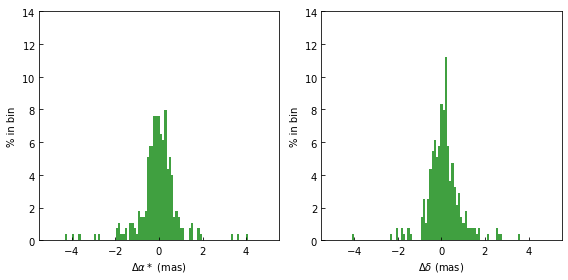

In [6]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dRA, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(dDC, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 16, 2))
ax1.set_yticks(np.arange(0, 16, 2))

ax0.set_ylim([0, 14])
ax1.set_ylim([0, 14])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

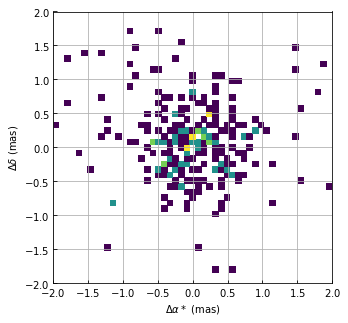

In [7]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(5, 5))

bins = np.linspace(-2, 2, 50)

# We can increase the number of bins on each axis
ax.hist2d(dRA, dDC, bins, norm=colors.LogNorm())

ax.set_xlabel("$\Delta\\alpha*$ (mas)")
ax.set_ylabel("$\Delta\\delta$ (mas)")

ax.grid(True)

plt.show()

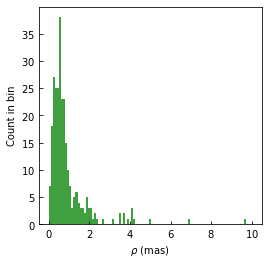

In [8]:
# Distribution of angular separation
bins_array = np.linspace(0, 10, 100)

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(ang_sep, bins_array, facecolor="g", alpha=0.75)

ax.set_xlabel("$\\rho$ (mas)")
ax.set_ylabel("Count in bin")

plt.show()

In [9]:
std_ra = np.std(dRA)
std_dec = np.std(dDC)
_, wrms_ra, _ = rms_calc(dRA, dRA_err)
_, wrms_dec, _ = rms_calc(dDC, dDC_err)

std_ra, std_dec, wrms_ra, wrms_dec

(2.574786650789976, 1.451994527886782, 0.8920250899095156, 0.944731127474818)

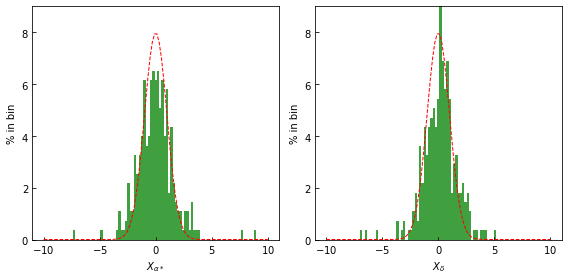

In [10]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(X_a, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(X_d, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylim([0, 9])
ax1.set_ylim([0, 9])

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 10, 2))
ax1.set_yticks(np.arange(0, 10, 2))

fig.tight_layout()
plt.show()

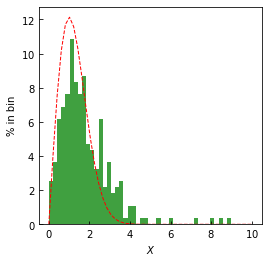

In [11]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X) * 100. / X.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

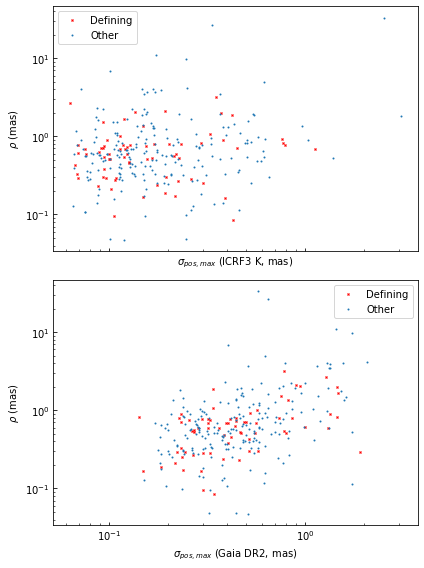

In [12]:
# Angular position difference vs. positional uncertainty
fig, (ax0, ax1) = plt.subplots(figsize=(6, 8), nrows=2, sharex=True)

ax0.plot(com_def["pos_err_icrf3k"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")
ax1.plot(com_def["pos_err_gaiadr2"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")

ax0.plot(com_oth["pos_err_icrf3k"],
         com_oth["ang_sep"], ".", ms=2, label="Other")
ax1.plot(com_oth["pos_err_gaiadr2"],
         com_oth["ang_sep"], ".", ms=2, label="Other")

ax0.set_xscale("log")
ax0.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax0.set_xlabel("$\sigma_{pos,max}$ (ICRF3 K, mas)")
ax0.set_ylabel("$\\rho$ (mas)")
ax1.set_xlabel("$\sigma_{pos,max}$ (Gaia DR2, mas)")
ax1.set_ylabel("$\\rho$ (mas)")


ax0.legend()
ax1.legend()

fig.tight_layout()
plt.show()

Then I investigate the systematics through the 16-parameters transformation.

In [13]:
# Try with all the sources
# Transform columns into np.array
dra = np.array(com_sou["dra"])
ddec = np.array(com_sou["ddec"])
dra_err = np.array(com_sou["dra_err"])
ddec_err = np.array(com_sou["ddec_err"])
ra_rad = np.array(com_sou["ra_icrf3k"].to(u.radian))
dec_rad = np.array(com_sou["dec_icrf3k"].to(u.radian))
dra_ddec_cov = np.array(com_sou["dra_ddec_cov"])

# Transformation parameters
# l_max = 1
w1_all, sig1_all, corrcoef1_all = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_all, sig2_all, corrcoef2_all = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_all * 1.e3
sig1 = sig1_all * 1.e3
w2 = w2_all * 1.e3
sig2 = sig2_all * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_all, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_all, deci_digit=1, included_one=False)

Estimates (   276 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   -27 +/-  75    +3 +/-  74   -45 +/-  74      -3 +/-  74   +19 +/-  76   -46 +/-  72
l_max=2    +7 +/-  78   +25 +/-  77   -30 +/-  75     -38 +/-  77   +39 +/-  78   -35 +/-  76
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       17    48
            EI22      -82    50
            ER21     -107    91
            EI21     -106    96
             E20      -72    89
            MR22       11    48
            MI22      -18    47
            MR21      126   108
     

In [14]:
# The last step is to save the 16 transformation parameters for further use.

vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf3k_gaiadr2_fnt_vsh02_all.log", format="ascii", overwrite=True)

In [15]:
# Remove the outlier (consider the normalized separation)
N = len(com_sou)
X0 = np.sqrt(np.log(N) * 2)

print("There are %d sources.\n"
      "When X >= %.2f, the number of the outlier is smaller than 1." % (N, X0))

mask = ((com_sou["nor_sep"] <= X0)
        & (com_sou["ang_sep"] < 10))

# Table of a clean sample
com_clean = com_sou[mask]
N1 = len(com_clean)
print("After elimination, there are %d sources in the clean sample." % N1)
print("The outlier rate is %.0f%%." % ((N-N1)/N*100))

There are 276 sources.
When X >= 3.35, the number of the outlier is smaller than 1.
After elimination, there are 247 sources in the clean sample.
The outlier rate is %11


In [16]:
# Transform columns into np.array
dra = np.array(com_clean["dra"])
ddec = np.array(com_clean["ddec"])
dra_err = np.array(com_clean["dra_err"])
ddec_err = np.array(com_clean["ddec_err"])
ra_rad = np.array(com_clean["ra_icrf3k"].to(u.radian))
dec_rad = np.array(com_clean["dec_icrf3k"].to(u.radian))
dra_ddec_cov = np.array(com_clean["dra_ddec_cov"])

In [17]:
# Transformation parameters
# l_max = 1
w1_cln, sig1_cln, corrcoef1_cln = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_cln, sig2_cln, corrcoef2_cln = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_cln * 1.e3
sig1 = sig1_cln * 1.e3
w2 = w2_cln * 1.e3
sig2 = sig2_cln * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_cln, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_cln, deci_digit=1, included_one=False)

Estimates (   247 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   +33 +/-  32   -71 +/-  31   -42 +/-  32     +22 +/-  32   -14 +/-  32    +4 +/-  31
l_max=2   +62 +/-  34   -55 +/-  33   -28 +/-  32      -3 +/-  33   +11 +/-  33    -5 +/-  32
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       18    20
            EI22      -45    21
            ER21      -34    38
            EI21      -80    42
             E20       15    38
            MR22       30    20
            MI22        7    20
            MR21       77    45
     

Then I check the residuals of positional offsets.

In [18]:
# Remove the systematics
RA = np.array(com_sou["ra_icrf3k"].to(u.radian))
DE = np.array(com_sou["dec_icrf3k"].to(u.radian))

dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_cln)
# dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_all)

# Now re-calculate the normalized difference
ang_sep_ns, Xa_ns, Xd_ns, X_ns = nor_sep_calc(
    dra_ns, dRA_err, ddec_ns, dDC_err, dRA_dDC_cov/dRA_err/dDC_err)

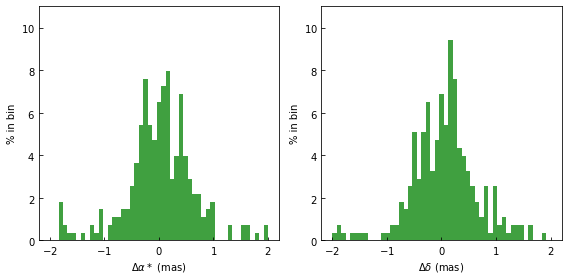

In [19]:
# Difference in RA and decl.
bins_array = np.linspace(-2, 2, 50)
weights = np.ones_like(dra_ns) * 100. / dra_ns.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dra_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(ddec_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 14, 2))
ax1.set_yticks(np.arange(0, 14, 2))

ax0.set_ylim([0, 11])
ax1.set_ylim([0, 11])
 
ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

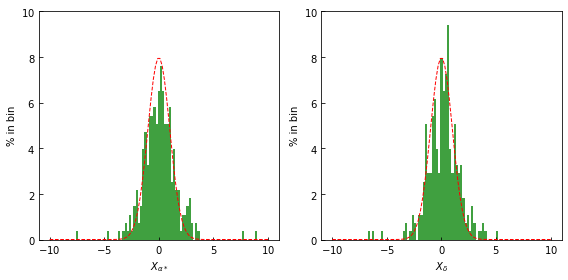

In [20]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(Xa_ns) * 100. / Xa_ns.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(Xa_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(Xd_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

fig.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

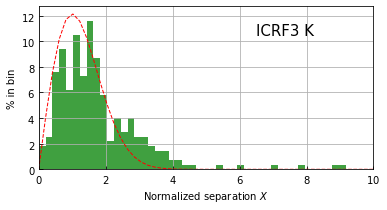

In [21]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X_ns) * 100. / X_ns.size

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(X_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.text(6.5, 10.5, "ICRF3 K", fontsize=15)

ax.set_xlim([0, 10])
ax.set_xlabel("Normalized separation $X$")
ax.set_ylabel("% in bin")
ax.grid()

plt.savefig("../plots/x_icrf3k_gaiadr2_fnt.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


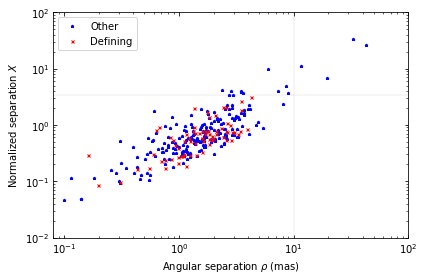

In [22]:
# Angular separation vs. normalized separation
fig, ax = plt.subplots()

ax.plot(com_oth["nor_sep"], com_oth["ang_sep"], "b*", ms=3, label="Other")
ax.plot(com_def["nor_sep"], com_def["ang_sep"], "rx", ms=3, label="Defining")
ax.vlines(10, 0.01, 100, colors="k", linestyles="dashed", lw=0.1)
ax.hlines(X0, 0.08, 100, colors="k", linestyles="dashed", lw=0.1)

ax.set_xscale("log")
ax.set_yscale("log")


ax.set_ylabel("Normalized separation $X$")
ax.set_xlabel("Angular separation $\\rho$ (mas)")

ax.set_xlim([0.08, 100])
ax.set_ylim([0.01, 100])

ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(loc="upper left")
fig.tight_layout()

plt.savefig("../plots/separation_icrf3k_gaiadr2_fnt.eps")

In [23]:
# The last step is to save the 16 transformation parameters for further use.

vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf3k_gaiadr2_fnt_vsh02.log", format="ascii", overwrite=True)